<a href="https://colab.research.google.com/github/git-sunao/path-integral/blob/main/notebooks/dev05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/git-sunao/path-integral/blob/main/notebooks/dev04.ipynb)

In [20]:
# Run this if in Google Colab
!git clone https://github.com/git-sunao/path-integral.git
%cd path-integral
!pip install -r requirements.txt

Cloning into 'path-integral'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 178 (delta 82), reused 147 (delta 54), pack-reused 0 (from 0)
Receiving objects: 100% (178/178), 6.03 MiB | 13.97 MiB/s, done.
Resolving deltas: 100% (82/82), done.
/content/path-integral/path-integral


In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jacobian
from getdist import MCSamples, plots

from tqdm import tqdm

import sys
sys.path.append("../")

from pldflow import plflow

import os
import jax
smoke_test = ('CI' in os.environ)
%matplotlib inline
cpu_device = jax.devices('cpu')[0]

In [23]:
class Fresnel(plflow.PicardLefschetzModelBaseClass):
    ndim = 1
    def action_s(self, z, y, p=1):
        return 1j*jnp.dot(z, z) - 2j*jnp.dot(z, y)

In [24]:
fresnel = Fresnel()

# Debugging

In [25]:
n_samples = 200
# integral variable
x1 = jnp.linspace(-5, 5, n_samples)
x2 = jnp.zeros((n_samples, fresnel.ndim-1))
x  = jnp.array([x1, *x2.T]).T
# parameter
y  = jnp.zeros(fresnel.ndim)
# flow time
# t = jnp.linspace(0, 1.0, 1000)
# t = jnp.linspace(0, 0.5, 100)
# t = jnp.linspace(0, 1e-3, 100)
# t = jnp.linspace(0, 1.0, 4)
t = jnp.linspace(0, 0.4, 100)


In [26]:
%time j = fresnel.vflow_jacobian(x, t, y=y, uselast=True)
%time j = fresnel.vflow_jacobian(x, t, y=y, uselast=True)

CPU times: user 709 ms, sys: 18.8 ms, total: 728 ms
Wall time: 740 ms
CPU times: user 3.12 ms, sys: 6 µs, total: 3.12 ms
Wall time: 3.13 ms


In [27]:
%time ja= fresnel.vflow_jacobian_approx(x, t, y=y, uselast=True, withz=False)
%time ja= fresnel.vflow_jacobian_approx(x, t, y=y, uselast=True, withz=False)

CPU times: user 292 ms, sys: 2.1 ms, total: 294 ms
Wall time: 277 ms
CPU times: user 5.44 ms, sys: 18 µs, total: 5.45 ms
Wall time: 3.44 ms


In [28]:
j.shape, ja.shape

((200,), (200,))

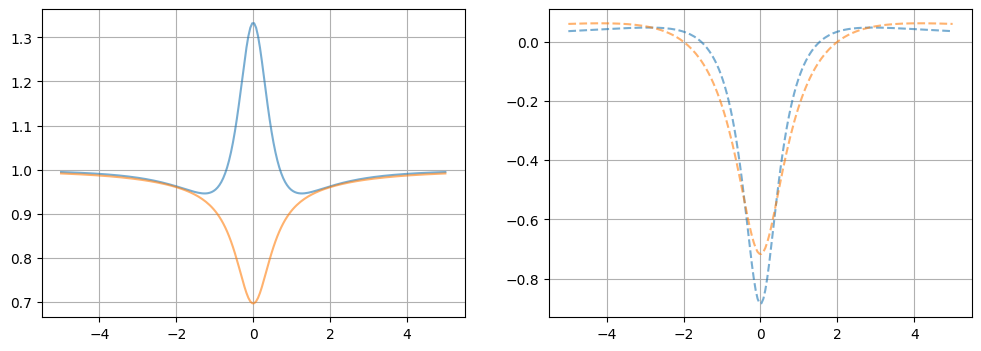

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(x[:,0], j.real , label='exact' , color='C0', alpha=0.6)
axes[0].plot(x[:,0], ja.real, label='approx', color='C1', alpha=0.6)
axes[0].grid()
axes[1].plot(x[:,0], j.imag , label='exact' , color='C0', ls='--', alpha=0.6)
axes[1].plot(x[:,0], ja.imag, label='approx', color='C1', ls='--', alpha=0.6)
axes[1].grid()
plt.show()

## Plotting gif

In [30]:
# fresnel.plot1dgif('temp.gif', x, t, y=y)

## Sampling

In [31]:
fresnel = Fresnel(ndim=5)
fresnel.rescale_velocity = False
t = jnp.linspace(0, 0.5, 100)

priors = {'x':(-5,5,fresnel.ndim), 'y':(-5,5,fresnel.ndim)}
sampler = plflow.HMCSampler(fresnel, priors)
sampler.sample(num_samples=10000, t=t)

/usr/local/lib/python3.10/dist-packages/jax/_src/lax/lax.py:2854: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
sample: 100%|██████████| 10500/10500 [03:26<00:00, 50.83it/s, 63 steps of size 6.01e-02. acc. prob=0.91]


Removed no burn in


<Figure size 400x400 with 0 Axes>

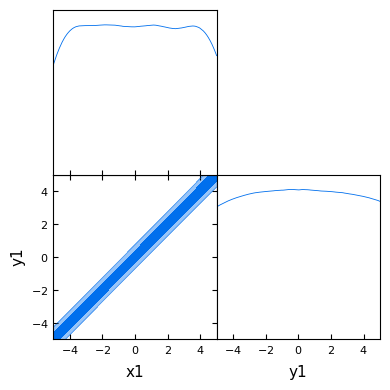

In [32]:
mcs = sampler.get_samples(format=MCSamples)

g = plots.get_single_plotter(ratio=1, width_inch=4)
g.triangle_plot(mcs, ['x1', 'y1'], filled=True)
plt.show()

## Normalizing flow training

Training MAF:  32%|███▏      | 317/1000 [00:24<00:53, 12.69it/s]


Early stopping at step 318 with best loss -3.5356783866882324


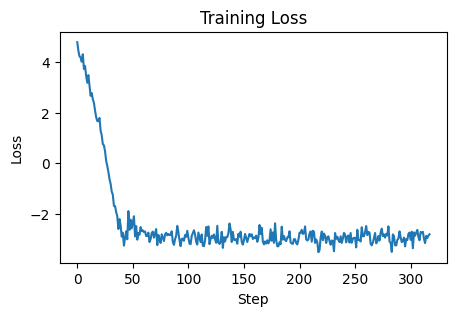

In [33]:
maf = plflow.MAFModel(sampler, process=True)

maf.build(hidden_dims=[128]*4, n_transforms=12)
maf.train(n_steps=1_000, batch_size=128, patience=100)
maf.plot_loss()

CPU times: user 1.05 ms, sys: 2 µs, total: 1.06 ms
Wall time: 1.03 ms
CPU times: user 3.24 ms, sys: 0 ns, total: 3.24 ms
Wall time: 3.13 ms


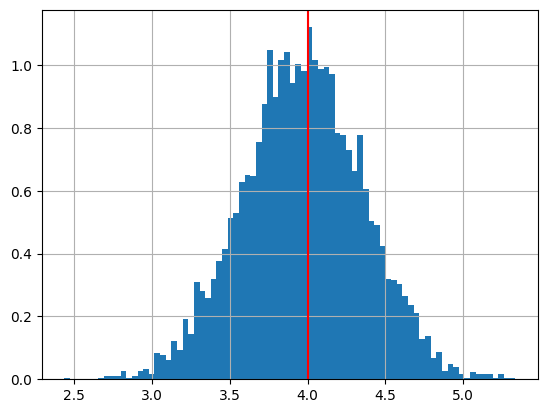

In [35]:
y = jnp.array([4.0]+[0.0]*(fresnel.ndim-1))
%time x = maf.sample(y, num_samples=5000, seed=5)
%time lnp = maf.log_prob(x, y)

a = jnp.argsort(x[:,0])
plt.hist(x[a,0], bins=80, density=True)
plt.axvline(y[0], color='r')
plt.grid()
plt.show()

## Evaluate the integral

In [36]:
y1 = jnp.linspace(-3, 3, 100)
y2 = jnp.zeros_like(y1)
y  = jnp.stack([y1]+[y2]*(fresnel.ndim-1), axis=1)

Z = []
for _y in tqdm(y):
    x = maf.sample(_y, num_samples=1000, seed=0, beta=1.0)
    lnp = maf.log_prob(x, _y, beta=1.0)
    _Z = fresnel.integrate(x, lnp, t, y=_y)
    Z.append(_Z)
Z = jnp.array(Z)

100%|██████████| 100/100 [00:09<00:00, 11.08it/s]


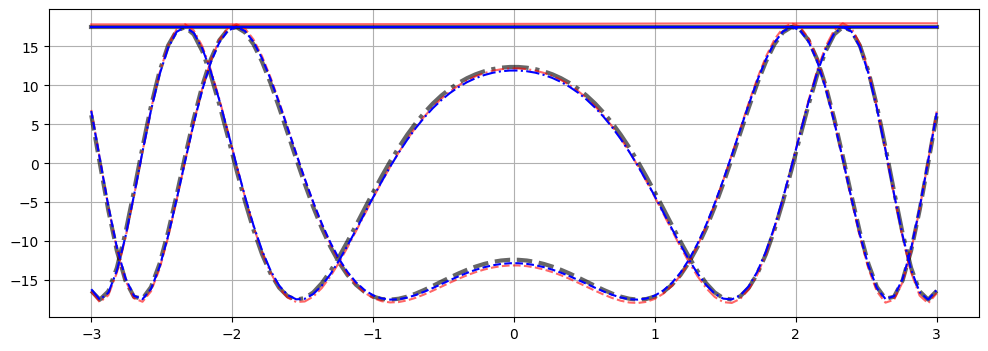

In [37]:
# Get analytic result
ndim = fresnel.ndim
Z_ana = jnp.exp(1j*y1**2) * ((1-1j)*jnp.sqrt(jnp.pi/2.0))**ndim

# Plotting
plt.figure(figsize=(12, 4))
# analytic
plt.plot(y1, jnp.real(Z_ana), color='k', ls='--', alpha=0.6, lw=3)
plt.plot(y1, jnp.imag(Z_ana), color='k', ls='-.', alpha=0.6, lw=3)
plt.plot(y1, jnp.abs(Z_ana) , color='k', ls='-' , alpha=0.6, lw=3)
# estimate
plt.plot(y1, jnp.real(Z), color='r', ls='--', alpha=0.6)
plt.plot(y1, jnp.imag(Z), color='r', ls='-.', alpha=0.6)
plt.plot(y1, jnp.abs(Z) , color='r', ls='-' , alpha=0.6)
# abs corrected
norm = jnp.abs(Z)/jnp.abs(Z_ana)
plt.plot(y1, jnp.real(Z)/norm, color='b', ls='--')
plt.plot(y1, jnp.imag(Z)/norm, color='b', ls='-.')
plt.plot(y1, jnp.abs(Z) /norm, color='b', ls='-')
plt.grid()
plt.show()

# Higher dimension

In [46]:
gpu_device = jax.devices('gpu')[0]

In [47]:
fresnel = Fresnel(ndim=10)
fresnel.rescale_velocity = False
t = jnp.linspace(0, 0.8, 100)

priors = {'x':(-5,5,fresnel.ndim), 'y':(-5,5,fresnel.ndim)}
sampler = plflow.HMCSampler(fresnel, priors)
with jax.default_device(gpu_device):
  sampler.sample(num_samples=10000, t=t)

/usr/local/lib/python3.10/dist-packages/jax/_src/lax/lax.py:2854: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
sample: 100%|██████████| 10500/10500 [09:25<00:00, 18.57it/s, 127 steps of size 2.95e-02. acc. prob=0.89]


Removed no burn in


<Figure size 400x400 with 0 Axes>

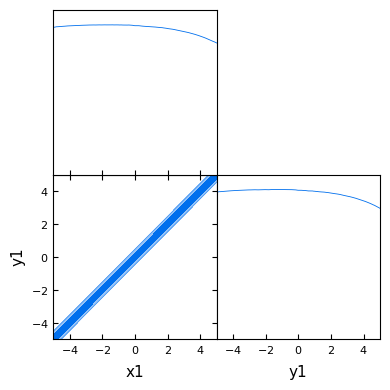

In [48]:
mcs = sampler.get_samples(format=MCSamples)

g = plots.get_single_plotter(ratio=1, width_inch=4)
g.triangle_plot(mcs, ['x1', 'y1'], filled=True)
plt.show()

Training MAF:  28%|██▊       | 284/1000 [00:36<01:32,  7.78it/s]


Early stopping at step 285 with best loss -12.357179641723633


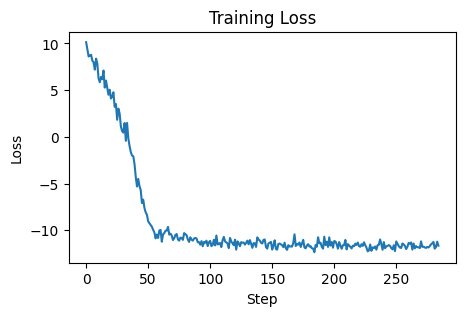

In [49]:
maf = plflow.MAFModel(sampler, process=True)

# maf.build(hidden_dims=[128]*3, n_transforms=12)
maf.build(hidden_dims=[200]*3, n_transforms=12)
maf.train(n_steps=1_000, batch_size=128, patience=100)
maf.plot_loss()

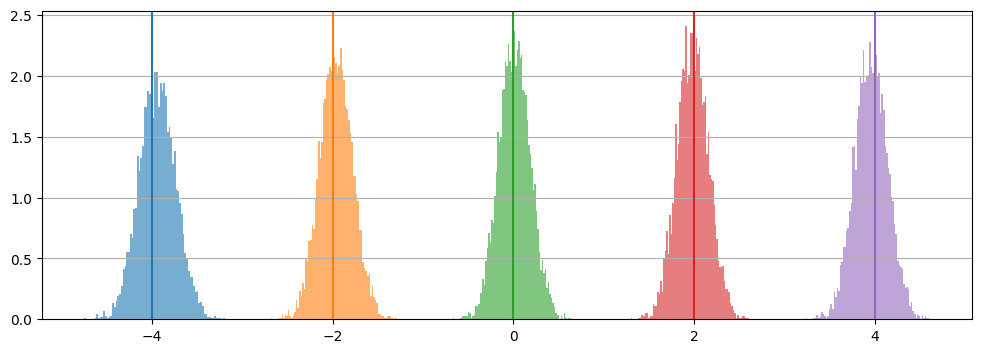

In [50]:
plt.figure(figsize=(12, 4))
for i, _y in enumerate([-4.0, -2.0, 0.0, 2.0, 4.0]):
    y   = jnp.array([_y]+[0.0]*(fresnel.ndim-1))
    x   = maf.sample(y, num_samples=5000, seed=5)
    lnp = maf.log_prob(x, y)
    a = jnp.argsort(x[:,0])
    plt.hist(x[a,0], bins=80, density=True, color=f'C{i}', alpha=0.6)
    plt.axvline(y[0], color=f'C{i}')
plt.grid()
plt.show()

In [51]:
y1 = jnp.linspace(-3, 3, 100)
y2 = jnp.zeros_like(y1)
y  = jnp.stack([y1]+[y2]*(fresnel.ndim-1), axis=1)

Z = []
for _y in tqdm(y):
    x = maf.sample(_y, num_samples=1000, seed=0, beta=1.0)
    lnp = maf.log_prob(x, _y, beta=1.0)
    _Z = fresnel.integrate(x, lnp, t, y=_y)
    Z.append(_Z)
Z = jnp.array(Z)

100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


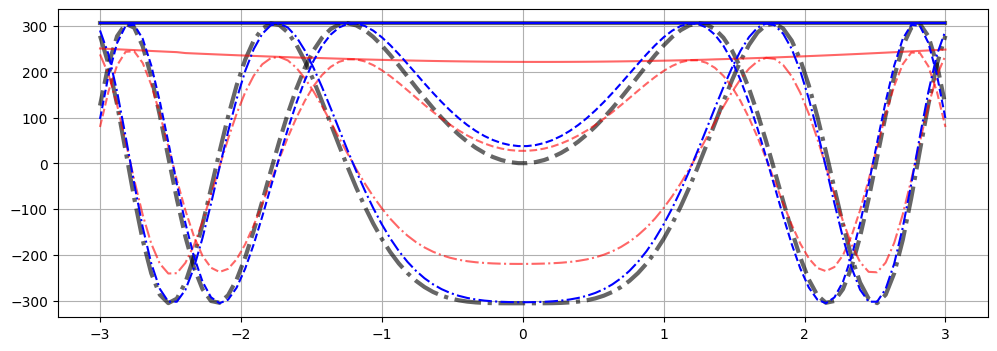

In [52]:
# Get analytic result
ndim = fresnel.ndim
Z_ana = jnp.exp(1j*y1**2) * ((1-1j)*jnp.sqrt(jnp.pi/2.0))**ndim

# Plotting
plt.figure(figsize=(12, 4))
# analytic
plt.plot(y1, jnp.real(Z_ana), color='k', ls='--', alpha=0.6, lw=3)
plt.plot(y1, jnp.imag(Z_ana), color='k', ls='-.', alpha=0.6, lw=3)
plt.plot(y1, jnp.abs(Z_ana) , color='k', ls='-' , alpha=0.6, lw=3)
# estimate
plt.plot(y1, jnp.real(Z), color='r', ls='--', alpha=0.6)
plt.plot(y1, jnp.imag(Z), color='r', ls='-.', alpha=0.6)
plt.plot(y1, jnp.abs(Z) , color='r', ls='-' , alpha=0.6)
# abs corrected
norm = jnp.abs(Z)/jnp.abs(Z_ana)
plt.plot(y1, jnp.real(Z)/norm, color='b', ls='--')
plt.plot(y1, jnp.imag(Z)/norm, color='b', ls='-.')
plt.plot(y1, jnp.abs(Z) /norm, color='b', ls='-')
plt.grid()
plt.show()

In [53]:
y1 = jnp.linspace(-3, 3, 100)
y2 = jnp.zeros_like(y1)
y  = jnp.stack([y1]+[y2]*(fresnel.ndim-1), axis=1)

Z = []
for _y in tqdm(y):
    # x = maf.sample(_y, num_samples=1000, seed=0, beta=1.0)
    x = maf.sample(_y, num_samples=300, seed=0, beta=1.0)
    lnp = maf.log_prob(x, _y, beta=1.0)
    _Z = fresnel.integrate_approx(x, lnp, t, y=_y)
    Z.append(_Z)
Z = jnp.array(Z)

100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


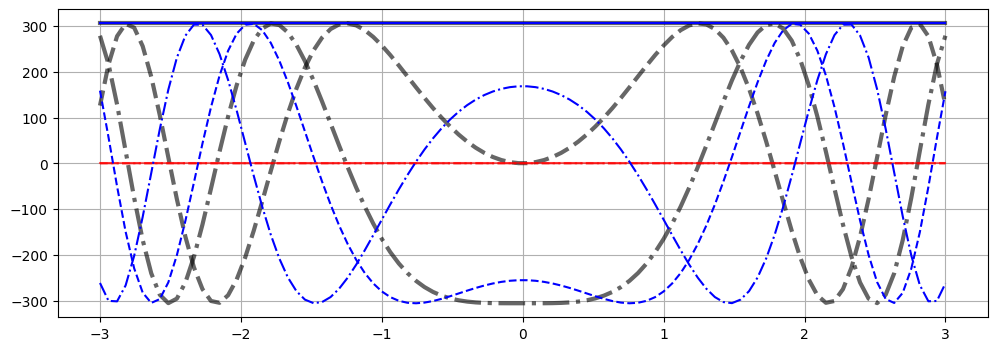

In [54]:
# Get analytic result
ndim = fresnel.ndim
Z_ana = jnp.exp(1j*y1**2) * ((1-1j)*jnp.sqrt(jnp.pi/2.0))**ndim

# Plotting
plt.figure(figsize=(12, 4))
# analytic
plt.plot(y1, jnp.real(Z_ana), color='k', ls='--', alpha=0.6, lw=3)
plt.plot(y1, jnp.imag(Z_ana), color='k', ls='-.', alpha=0.6, lw=3)
plt.plot(y1, jnp.abs(Z_ana) , color='k', ls='-' , alpha=0.6, lw=3)
# estimate
plt.plot(y1, jnp.real(Z), color='r', ls='--', alpha=0.6)
plt.plot(y1, jnp.imag(Z), color='r', ls='-.', alpha=0.6)
plt.plot(y1, jnp.abs(Z) , color='r', ls='-' , alpha=0.6)
# abs corrected
norm = jnp.abs(Z)/jnp.abs(Z_ana)
plt.plot(y1, jnp.real(Z)/norm, color='b', ls='--')
plt.plot(y1, jnp.imag(Z)/norm, color='b', ls='-.')
plt.plot(y1, jnp.abs(Z) /norm, color='b', ls='-')
plt.grid()
plt.show()